In [1]:
import os
from glob import glob

import numpy as np
import pandas as pd
import xarray as xr

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

%matplotlib widget
import matplotlib.pyplot as plt

In [2]:
cloud_dfN = pd.read_parquet("../data/caliop-slstr-greenland-maxsza80.parquet")
print(len(cloud_dfN))

1244598


In [3]:
cloud_dfS = pd.read_parquet("../data/caliop-slstr-antarctic-maxsza80.parquet")
print(len(cloud_dfS))

235122


In [4]:
cloud_df = pd.concat((cloud_dfN, cloud_dfS))
cloud_df = cloud_df.sample(frac = 1, random_state=7273)

In [5]:
len(cloud_dfN), len(cloud_dfS)

(1244598, 235122)

could proportion: 0.47275971129673183


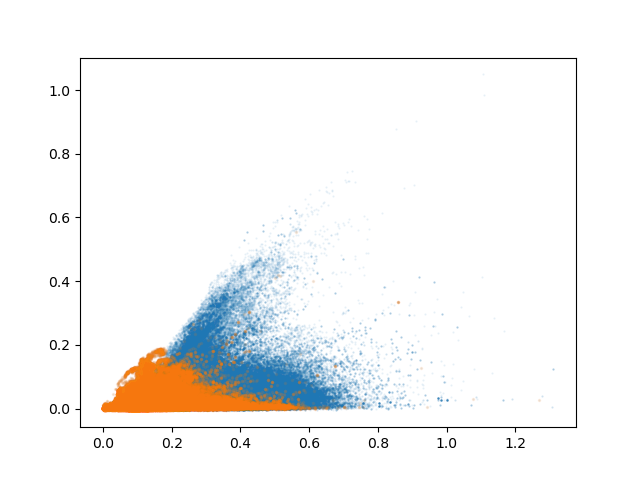

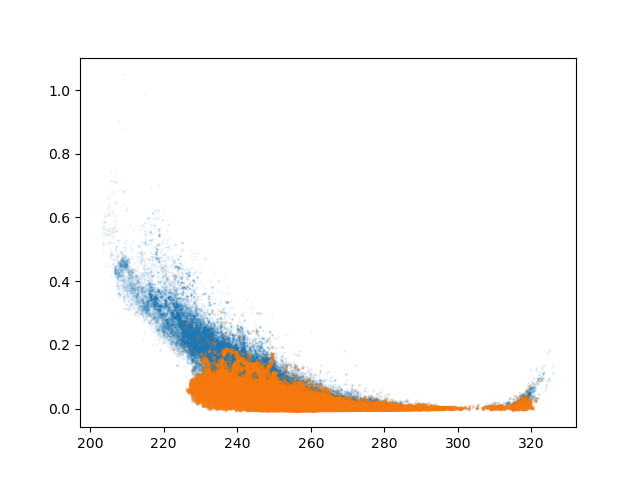

In [6]:
df= cloud_df

cloud = df['Number_Layers_Found'] > 0

#plt.figure()
print("could proportion:", cloud.mean())
plt.figure()
plt.plot(df.S5, df.S4, '.', markersize=1, alpha=0.1)
plt.plot(df.S5[~cloud], df.S4[~cloud], '.', markersize=3, alpha=0.1)
#plt.plot(df.S5[cloud], df.S4[cloud], '.', markersize=3, alpha=0.1)

plt.figure()
plt.plot(df.S8, df.S4, '.', markersize=1, alpha=0.1)
plt.plot(df.S8[~cloud], df.S4[~cloud], '.', markersize=3, alpha=0.1)
#plt.plot(df.S8[cloud], df.S4[cloud], '.', markersize=3, alpha=0.1)


In [7]:

inputs = ['S1', 'S2', 'S3', 'S4', 'S5', 'S7_std', 'S8_std', 'S9_std', 'vza_std', 'sza_std', 'aa_std']



class CloudDataset(Dataset):
    def __init__(self, cloud_data):
        self.data = cloud_data.copy()
        self.data['S7_std'] = (self.data['S7'] - 200) / 73
        self.data['S8_std'] = (self.data['S8'] - 200) / 73
        self.data['S9_std'] = (self.data['S9'] - 200) / 73
        
        self.data['vza_std'] = self.data['satellite_zenith_angle'] / 90
        self.data['sza_std'] = self.data['solar_zenith_angle'] / 90
        self.data['aa_std'] = ((self.data['satellite_azimuth_angle'] - self.data['solar_azimuth_angle']) % 360) / 360

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        data = self.data.iloc[idx]
        
        #'Latitude', 'Longitude', 'Profile_UTC_Time', 'IGBP_Surface_Type',
        #'Number_Layers_Found', 'geometry', 'S1', 'S2', 'S3', 'S4', 'S5', 'S7',
        #'S8', 'S9', 'bayes', 'cloud', 'confidence', 'latitude', 'longitude',
        #'pointing', 'satellite_azimuth_angle', 'satellite_zenith_angle',
        #'solar_azimuth_angle', 'solar_zenith_angle'],
        
        cloud = float(data['Number_Layers_Found'] > 0)

        data = data[inputs].values.astype(np.float32)
        data = np.clip(data, -1, +1.3)
        return data - 0.5, np.array([cloud, 1 - cloud])

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(len(inputs), 32),
            nn.LeakyReLU(),
            nn.Linear(32, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 2),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits


model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=11, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=32, out_features=2, bias=True)
    (5): Softmax(dim=1)
  )
)


In [8]:
# Pour model1:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [9]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    print("size=", size)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 1000 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
            
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            
            # correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    # correct /= size
    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")

    
def errors(dataloader, model, threshold=0.5):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    
    good_detected_cloud = 0
    wrong_detected_cloud = 0
    
    good_detected_clear = 0
    wrong_detected_clear = 0
    is_cloud = 0
    is_not_cloud = 0
    
    if isinstance(threshold, np.ndarray):
        threshold = torch.from_numpy(threshold[np.newaxis, :])
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            
            cloud_detected = pred[:, 0][:, None] > threshold
            clear_detected = pred[:, 0][:, None] < threshold
            
            good_detected_cloud += torch.sum(cloud_detected & (y[:, 0][:, None] == 1), axis=0)
            wrong_detected_cloud += torch.sum(cloud_detected & (y[:, 0][:, None] == 0), axis=0)
            
            good_detected_clear += torch.sum(clear_detected & (y[:, 0][:, None] == 0), axis=0)
            wrong_detected_clear += torch.sum(clear_detected & (y[:, 0][:, None] == 1), axis=0)
            
            is_cloud += torch.sum(y[:, 0] == 1, axis=0)
            is_not_cloud += torch.sum(y[:, 0] == 0, axis=0)
    
    return pd.DataFrame({'TPR': good_detected_cloud / is_cloud, 
                         'FPR': wrong_detected_cloud / is_not_cloud,
                         'TPR_clear': good_detected_clear / is_not_cloud,
                         'FPR_clear': wrong_detected_clear / is_cloud})
    

    
training_size = len(cloud_df) // 10
test_size = training_size

batch_size = 10

train_dataloader = DataLoader(CloudDataset(cloud_df[:training_size]), batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(CloudDataset(cloud_df[-test_size:]), batch_size=10000, shuffle=False)

testS_dataloader = DataLoader(CloudDataset(cloud_dfS), batch_size=10000, shuffle=False)
testN_dataloader = DataLoader(CloudDataset(cloud_dfN), batch_size=10000, shuffle=False)

In [10]:
len(cloud_df)

1479720

In [11]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

#['S1', 'S2', 'S3', 'S4', 'S5', 'S8_std', 'S9_std', 'vza_std', 'sza_std', 'aa_std']

Epoch 1
-------------------------------
size= 147972
loss: 0.680140  [    0/147972]
loss: 0.427018  [10000/147972]


KeyboardInterrupt: 

In [ ]:
threshold = np.array(
            list(np.linspace(0, 0.1, 100)) +
            list(np.linspace(0.1, 0.8, 100)) +
            list(np.linspace(0.8, 0.98, 100)) +
            list(np.linspace(0.98, 1, 100))
            )

err = errors(test_dataloader, model, threshold=threshold)
errN = errors(testN_dataloader, model, threshold=threshold)
errS = errors(testS_dataloader, model, threshold=threshold)
err.to_csv("Errors/err-reference1.csv")

In [ ]:
plt.figure()
plt.plot(err.FPR, err.TPR, '-', label='NN')
plt.plot(errN.FPR, errN.TPR, '-', label='NN Greenland')
plt.plot(errS.FPR, errS.TPR, '-', label='NN Antarctic')

plt.plot(0.122289, 0.809558, 's', label="SCDA Greenland")
plt.plot(0.102724, 0.465246, 's', label="SCDA Antarctic")
plt.grid(alpha=0.2)
plt.legend()
plt.xlabel("False positive")
plt.ylabel("True positive")
plt.title("Cloud detection")